This notebook explores implementation of differential coulometry spectroscopy (DCS) targeted at the Borealis dataset used in this project, based on [BioLogic: Differential Coulometry Spectroscopy (DCS) Battery](https://www.biologic.net/documents/dcs-battery-application-note-57/) and [BioLogic: Investigating Battery Aging using Differential Capacity Analysis (DCA)](https://www.biologic.net/topics/investigating-battery-ageing-using-differential-capacity-analysis-dca/).

In [1]:
from pathlib import Path
import re
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [2]:
# Define standard column aliases
T = 'Test_Time(s)'
I = 'Current(A)'
V = 'Voltage(V)'
V_sm = 'Voltage_sm (V)'
Qc = 'Charge_Capacity(Ah)'
Qd = 'Discharge_Capacity(Ah)'
Ec = 'Charge_Energy(Wh)'
Ed = 'Discharge_Energy(Wh)'
P = 'Power(W)'

In [3]:
df = pd.read_excel(r"D:\FUSE 2025 SUM\battery-analysis-project\Data\raw_data\03-CONSTANT CURRENT protocol_Cycles 0 to 1000\Cycle 0370\CC_eleven_Channel_5_Wb_1.xlsx") # randomly picked

In [4]:
df = df[df['Cycle_Index']==1] # pick out a nice, complete cycle - info from previous work

In [5]:
# interpolate voltage vs time since raw dt is not constant
uniform_T = np.linspace(df[T].min(), df[T].max(), 100000)
interp_vt = interp1d(df[T],df[V],kind = 'cubic')
uniform_V = interp_vt(uniform_T)

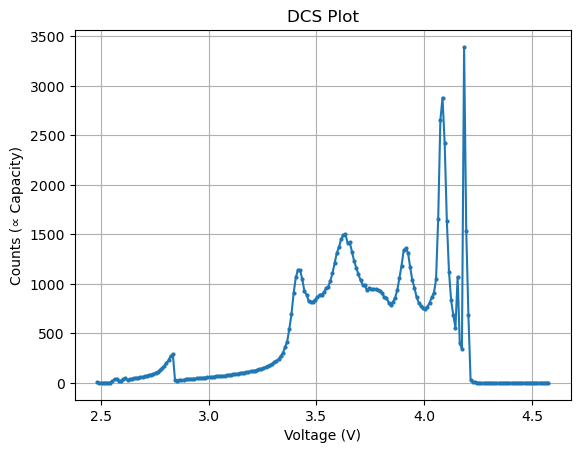

In [6]:
# 1. Choose voltage range and bin width
v_min, v_max = uniform_V.min(), uniform_V.max()
bins = np.arange(v_min, v_max, 0.01)  # bin width = 10 mV

# 2. Compute histogram: counts of data points in each voltage bin
counts, edges = np.histogram(uniform_V, bins=bins)

# 3. Normalize if needed (e.g., per cycle)
# counts = counts / np.sum(counts)

# 4. Plot DCS as histogram or smoothed curve
voltages = (edges[:-1] + edges[1:]) / 2
plt.plot(voltages, counts, marker = 'o', linestyle = '-', markersize= 2)
plt.xlabel("Voltage (V)")
plt.ylabel("Counts (∝ Capacity)")
plt.title("DCS Plot")
plt.grid(True)
plt.show()

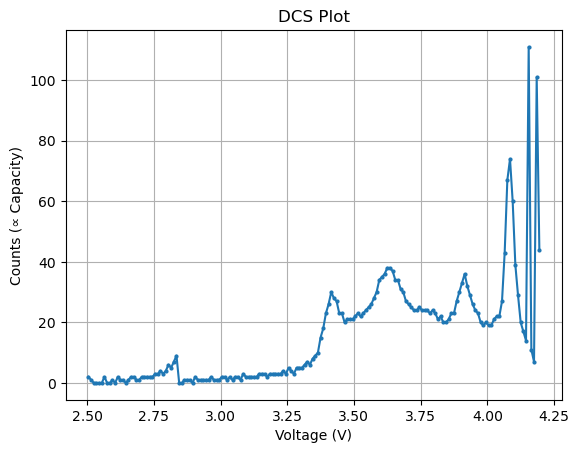

In [7]:
# without interpolation
# 1. Choose voltage range and bin width
v_min, v_max = df[V].min(), df[V].max()
bins = np.arange(v_min, v_max, 0.01)  # bin width = 10 mV

# 2. Compute histogram: counts of data points in each voltage bin
counts, edges = np.histogram(df[V], bins=bins)

# 3. Normalize if needed (e.g., per cycle)
# counts = counts / np.sum(counts)

# 4. Plot DCS as histogram or smoothed curve
voltages = (edges[:-1] + edges[1:]) / 2
plt.plot(voltages, counts, marker = 'o', linestyle = '-', markersize= 2)
plt.xlabel("Voltage (V)")
plt.ylabel("Counts (∝ Capacity)")
plt.title("DCS Plot")
plt.grid(True)
plt.show()

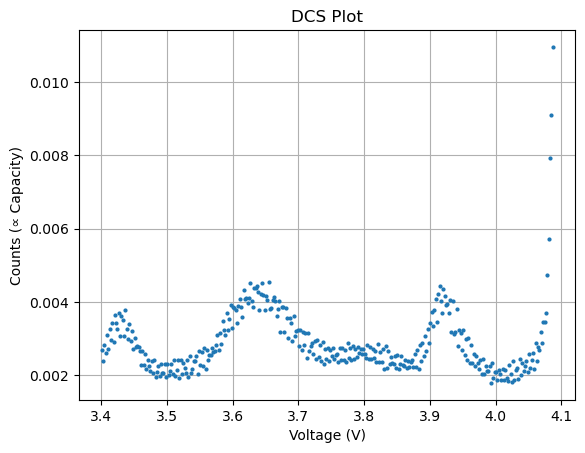

In [8]:
# look at charge and discharge separately to enable comparison with plots generated by other methods for monotonic segments

# ---CHARGE---
mask_c = (df[Qc] >= 0.2) & (df[Qc] <= 2.5)
df = df[mask_c]

uniform_T = np.linspace(df[T].min(), df[T].max(), 1000000)
interp_vt = interp1d(df[T],df[V],kind = 'cubic')
uniform_V = interp_vt(uniform_T)
# 1. Choose voltage range and bin width
v_min, v_max = uniform_V.min(), uniform_V.max()
bins = np.arange(v_min, v_max, 0.002)

# 2. Compute histogram: counts of data points in each voltage bin
counts, edges = np.histogram(uniform_V, bins=bins)

# 3. Normalize
counts = counts / np.sum(counts)

# 4. Plot DCS as histogram or smoothed curve
voltages = (edges[:-1] + edges[1:]) / 2
plt.plot(voltages, counts, marker = 'o', linestyle = 'none', markersize= 2)
plt.xlabel("Voltage (V)")
plt.ylabel("Counts (∝ Capacity)")
plt.title("DCS Plot")
plt.grid(True)
plt.show()

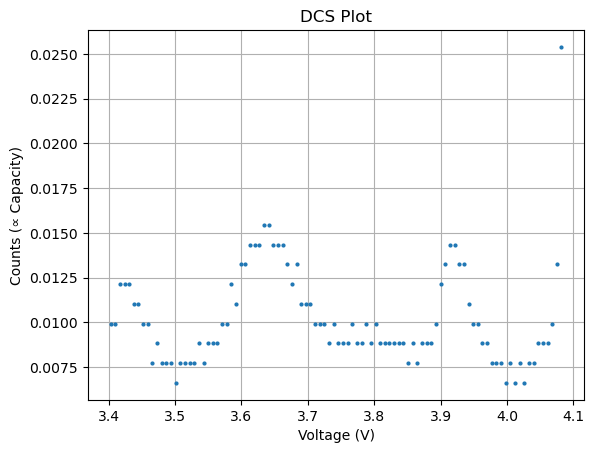

In [9]:
# without interpolation
# 1. Choose voltage range and bin width
v_min, v_max = df[V].min(), df[V].max()
bins = np.arange(v_min, v_max, 0.007)

# 2. Compute histogram: counts of data points in each voltage bin
counts, edges = np.histogram(df[V], bins=bins)

# 3. Normalize if needed (e.g., per cycle)
counts = counts / np.sum(counts)

# 4. Plot DCS as histogram or smoothed curve
voltages = (edges[:-1] + edges[1:]) / 2
plt.plot(voltages, counts, marker = 'o', linestyle = 'none', markersize= 2)
plt.xlabel("Voltage (V)")
plt.ylabel("Counts (∝ Capacity)")
plt.title("DCS Plot")
plt.grid(True)
plt.show()

<BarContainer object of 98 artists>

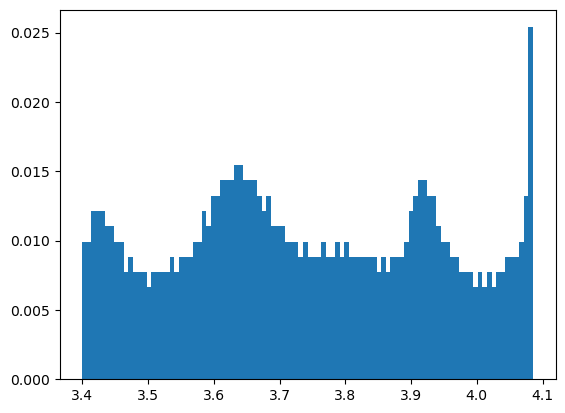

In [10]:
# want to avoid the influence of having tiny bins
bin_width = edges[1] - edges[0]
plt.bar(voltages, counts, width=bin_width, align='center')

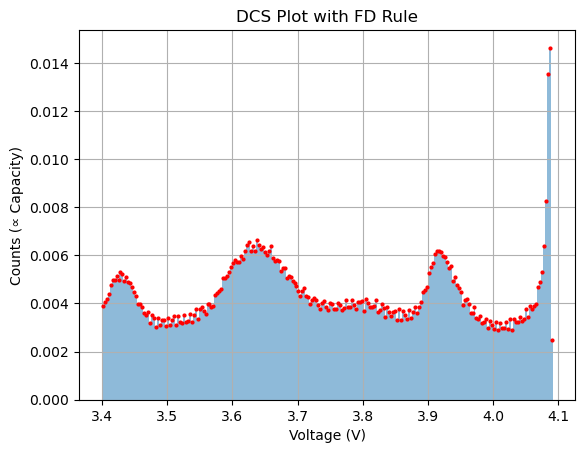

In [14]:
# use Freedom-Diaconis Rule to deterime bin width
uniform_T = np.linspace(df[T].min(), df[T].max(), 9990000)
interp_vt = interp1d(df[T],df[V],kind = 'linear')
uniform_V = interp_vt(uniform_T)
# 1. Calculate FD bin width
n = len(uniform_V)
q75, q25 = np.percentile(uniform_V, [75 ,25])
iqr = q75 - q25
bin_width = 2 * iqr / (n ** (1/3))
bin_width = max(bin_width, 1e-4)
v_min, v_max = uniform_V.min(), uniform_V.max()
edges = np.arange(v_min, v_max + bin_width, bin_width)

# 2. Compute histogram using your custom bins
counts, edges = np.histogram(uniform_V, bins=edges)

# 3. Normalize and plot
counts = counts / np.sum(counts)
voltages = 0.5 * (edges[:-1] + edges[1:])
plt.plot(voltages, counts, marker='o', linestyle='none', markersize=2, color='red')
plt.bar(voltages, counts, width=bin_width, align='center', alpha=0.5)
plt.xlabel("Voltage (V)")
plt.ylabel("Counts (∝ Capacity)")
plt.title("DCS Plot with FD Rule")
plt.grid(True)
plt.show()